In [61]:
import zipfile
import numpy as np

import torch
from transformers import AutoProcessor, AutoModelForCTC
from torch.utils.data import Dataset

from IPython.display import clear_output
clear_output()

In [26]:
# set espeak library path for macOS
import sys
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

# Load Data

In [34]:
TIMIT2IPA = {'AA': 'ɑ', 'AE': 'æ', 'AH': 'ʌ', 'AH0': 'ə', 'AO': 'ɔ', 'AW': 'aʊ', 'AY': 'aɪ', 'EH': 'ɛ', 'ER': 'ɝ', 'ER0': 'ɚ', 'EY': 'eɪ', 'IH': 'ɪ', 'IH0': 'ɨ', 'IY': 'i', 'OW': 'oʊ', 'OY': 'ɔɪ', 'UH': 'ʊ', 'UW': 'u', 'B': '', 'CH': 'tʃ', 'D': '', 'DH': 'ð', 'EL': 'l̩', 'EM': 'm̩', 'EN': 'n̩', 'F': 'f', 'G': '', 'HH': 'h', 'JH': 'dʒ', 'K': '', 'L': 'l', 'M': 'm', 'N': 'n', 'NG': 'ŋ', 'P': '', 'Q': 'ʔ', 'R': 'ɹ', 'S': 's', 'SH': 'ʃ', 'T': '', 'TH': 'θ', 'V': 'v', 'W': 'w', 'WH': 'ʍ', 'Y': 'j', 'Z': 'z', 'ZH': 'ʒ', 'AX': 'ə', 'AX-H': 'ə̥', 'AXR': 'ɚ', 'BCL': 'b', 'DCL': 'd', 'DX': 'ɾ', 'ENG': 'ŋ̍', 'EPI': '', 'GCL': 'g', 'HV': 'ɦ', 'H#': '', 'IX': 'ɨ', 'KCL': 'k', 'NX': 'ɾ̃', 'PAU': '', 'PCL': 'p', 'TCL': 't', 'UX': 'ʉ'}
IPA_SUBSTITUTIONS = {
    'ɾ̃': 'ɾ',  # Replace nasalized flap with plain flap
    'ŋ̍': 'ŋ',  # Remove syllabic marker from 'ŋ̍'
    'ə̥': 'ə',  # Remove voiceless marker from 'ə̥'
    'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
    'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
    'l̩': 'l',   # Remove syllabic marker from 'l̩'
    'm̩': 'm',   # Remove syllabic marker from 'm̩'
    'n̩': 'n',   # Remove syllabic marker from 'n̩'
    '̩': '',     # Remove syllabic marker
    'ʉ': 'u',    # Replace high central rounded vowel with high back rounded vowel
    'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
    ' ': '',     # Remove nasalization marker
    'ɦ': 'h',    # Replace voiceless glottal fricative with voiceless glottal fricative
}
for k in TIMIT2IPA.keys():
    if TIMIT2IPA[k] in IPA_SUBSTITUTIONS.keys():
        TIMIT2IPA[k] = IPA_SUBSTITUTIONS[TIMIT2IPA[k]]

In [134]:
WAV_HEADER_SIZE = 44
class TIMITDataset(Dataset):
    def __init__(self, split="train", include_timestamps=False):
        self.zip = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
        files = self.zip.namelist()
        self.files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/' + split.upper()), files))))
        self.include_timestamps = include_timestamps

    def __del__(self):
        self.zip.close()

    def __len__(self):
        return len(self.files)

    def _get_file(self, filename):
        with self.zip.open(filename+ '.WAV') as wav_file:
            audio = np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

        with self.zip.open(filename + '.PHN') as phn_file:
            timestamped_phonemes = []
            for line in phn_file.read().decode('utf-8').split('\n'):
                if line == '':
                    continue
                start, end, phoneme = line.split()
                ipa_phonemes = TIMIT2IPA.get(phoneme.upper(), '<unk>')
                timestamped_phonemes.append((ipa_phonemes, int(start), int(end)))
        ipa = ''.join([x[0] for x in timestamped_phonemes])
        
        start_signal = timestamped_phonemes.pop(0)
        audio = audio[start_signal[2]:]
        timestamped_phonemes = [(x[0], x[1] - start_signal[2], x[2] - start_signal[2]) for x in timestamped_phonemes]
        
        if self.include_timestamps:
            return ipa, audio, timestamped_phonemes
        else:
            return ipa, audio

    def __getitem__(self, index):
        filenames = self.files[index]
        if isinstance(filenames, str):
            return self._get_file(filenames)
        else:
            return [self._get_file(filename) for filename in filenames]

In [135]:
train = TIMITDataset("train", include_timestamps=True)
test = TIMITDataset("test", include_timestamps=True)

('wʌtɑɹgitshævwisəksɛsflinɑkaʊt', array([ 2,  1,  3, ..., -1, -3, 11], dtype=int16), [('w', 0, 413), ('ʌ', 413, 1081), ('t', 1081, 2580), ('', 2580, 3210), ('ɑ', 3210, 4026), ('ɹ', 4026, 4680), ('g', 4680, 5196), ('i', 5196, 6280), ('t', 6280, 6500), ('s', 6500, 7660), ('h', 7660, 7990), ('æ', 7990, 8997), ('v', 8997, 9561), ('w', 9561, 10333), ('i', 10333, 11105), ('s', 11105, 12423), ('ə', 12423, 12760), ('k', 12760, 13529), ('s', 13529, 14846), ('ɛ', 14846, 15830), ('s', 15830, 17040), ('f', 17040, 17895), ('l', 17895, 18898), ('i', 18898, 19826), ('n', 19826, 20987), ('ɑ', 20987, 22658), ('k', 22658, 24390), ('', 24390, 24670), ('aʊ', 24670, 27080), ('t', 27080, 28180), ('', 28180, 29280)])


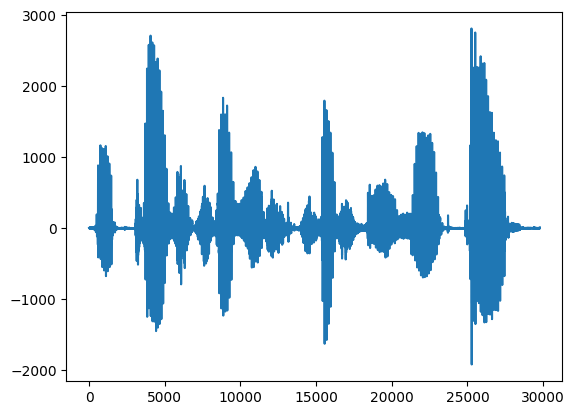

In [136]:
import matplotlib.pyplot as plt
print(train[0])
plt.plot(train[0][1])
plt.show()

# Evaluate Timestamps

In [30]:
# MODEL_ID = "KoelLabs/xlsr-timit-b0"
# MODEL_ID = "KoelLabs/xlsr-timit-c0"
# MODEL_ID = "KoelLabs/xlsr-timit-d0"
# MODEL_ID = "KoelLabs/xlsr-timit-e0"
# MODEL_ID = "KoelLabs/xlsr-timit-b1"
# MODEL_ID = "KoelLabs/xlsr-timit-c1"
# MODEL_ID = "KoelLabs/xlsr-timit-d1"
# MODEL_ID = "KoelLabs/xlsr-timit-e1"
# MODEL_ID = "facebook/wav2vec2-lv-60-espeak-cv-ft"
MODEL_ID = "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"
# MODEL_ID = "vitouphy/wav2vec2-xls-r-300m-timit-phoneme"
# MODEL_ID = "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
torch.mps.empty_cache()
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = AutoModelForCTC.from_pretrained(MODEL_ID).to(DEVICE)

In [11]:
SAMPLE_RATE = 16000
DIPHONES = {'aʊ', 'aɪ', 'eɪ', 'oʊ', 'ɔɪ', 'tʃ', 'dʒ'}
def transcribe_batch_timestamped(batch):
    input_values = processor([x[1] for x in batch], sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True).input_values.type(torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)

    for ids in predicted_ids:
        # transcription = processor.decode(ids)

        # get the start and end timestamp for each phoneme
        ids = ids.tolist()
        duration_sec = input_values.shape[1]

        ids_w_time = [
            (i / len(ids) * duration_sec, _id)
            for i, _id in enumerate(ids)
        ]

        # group the phonemes with the same id together
        current_phoneme_id = processor.tokenizer.pad_token_id
        current_start_time = 0
        phonemes_with_time = []
        for time, _id in ids_w_time:
            if current_phoneme_id != _id:
                if current_phoneme_id != processor.tokenizer.pad_token_id:
                    phonemes_with_time.append(
                        (processor.decode(current_phoneme_id), int(current_start_time), int(time))
                    )
                current_start_time = time
                current_phoneme_id = _id

        # group together characters that are diphones
        grouped_phonemes_with_time = []
        previous_phoneme = ''
        for phoneme, start, end in phonemes_with_time:
            if (previous_phoneme + phoneme) in DIPHONES:
                grouped_phonemes_with_time[-1] = (grouped_phonemes_with_time[-1][0] + phoneme, grouped_phonemes_with_time[-1][1], end)
            else:
                grouped_phonemes_with_time.append((phoneme, start, end))
            previous_phoneme = phoneme

        yield grouped_phonemes_with_time

In [12]:
for x, y in zip(list(transcribe_batch_timestamped([test[9]]))[0], [y for y in test[9][2] if y[0].strip() != '']):
    print(x, y)

('ɹ', 643, 965) ('ɹ', 0, 846)
('æ', 1931, 2253) ('ɑ', 846, 2540)
('l', 2896, 3218) ('l', 2540, 3400)
('f', 4506, 4827) ('f', 3400, 4920)
('k', 6115, 6437) ('k', 4920, 5720)
('n', 7402, 7724) ('n', 6360, 7776)
('t', 8690, 9333) ('t', 7776, 8080)
('ɹ', 9655, 10299) ('ɹ', 9700, 10536)
('oʊ', 10943, 11908) ('oʊ', 10536, 11700)
('l', 11908, 12552) ('l', 11700, 12360)
('d', 13196, 13839) ('d', 12360, 13700)
('ð', 14161, 14483) ('ð', 13700, 13880)
('ə', 14805, 15127) ('i', 13880, 15030)
('s', 17058, 17380) ('s', 15030, 17240)
('t', 18024, 18346) ('t', 17240, 17620)
('ɑ', 19633, 19955) ('ɑ', 18020, 20280)
('p', 21564, 21886) ('p', 20280, 21412)
('w', 22530, 23173) ('w', 22480, 23213)
('ɑ', 23817, 24139) ('ɑ', 23213, 24680)
('t', 24783, 25426) ('t', 24680, 25340)
('tʃ', 25748, 27358) ('tʃ', 25340, 27121)
('f', 29932, 30254) ('f', 27121, 29940)
('ɹ', 30254, 30576) ('ɹ', 29940, 30588)
('m', 31542, 31864) ('m', 30588, 31620)
('ð', 32507, 32829) ('n', 31620, 32262)
('ə', 33151, 33473) ('ə', 32262, 

In [405]:
timestamped_transcriptions = list(transcribe_batch_timestamped(test[:10]))
for timestamped_transcription in timestamped_transcriptions:
    print(len(timestamped_transcription), [y[0] for y in timestamped_transcription])

20 ['i', 's', 'h', 'ɛ', 'l', 'θ', 'j', 'ɹ', 'd', 'k', 'ʊ', 'k', 'w', 'ə', 'θ', 'aʊ', 'tʃ', 'ʊ', 'ɡ', 'ɹ']
28 ['tʃ', 'i', 'p', 's', 't', 'ɑ', 'k', 'i', 'ŋ', 'z', 'ɹ', 'ʌ', 'n', 'ð', 'ə', 'f', 'ɹ', 's', 't', 'aɪ', 'm', 'ð', 'ɛ', 'ɹ', 'w', 'ɔ', 'n', 'd']
37 ['ð', 'ə', 'b', 'v', 'ʌ', 'ŋ', 'ɡ', 'ə', 'l', 'oʊ', 'w', 'ə', 'z', 'p', 'l', 'ʌ', 'z', 'n', 'l', 'i', 's', 'ɪ', 't', 'tʃ', 'u', 'w', 'eɪ', 'ɾ', 'i', 'd', 'n', 'i', 'ð', 'i', 'ʃ', 'ɔ', 'ɹ']
34 ['ʃ', 'i', 'h', 'æ', 'd', 'j', 'ɹ', 'd', 'ɑ', 'ɹ', 'k', 's', 'u', 't', 'n', 'ɡ', 'ɹ', 'i', 's', 'i', 'b', 'w', 'ɔ', 'ʃ', 'w', 'ɔ', 'ɾ', 'ɹ', 'ʔ', 'ɔ', 'l', 'j', 'ɪ', 'ɹ']
27 ['oʊ', 'ɾ', 'æ', 's', 'k', 'm', 'i', 'ɾ', 'i', 'k', 'ɛ', 'ɹ', 'ɪ', 'i', 'n', 'ɔɪ', 'l', 'i', 'ɹ', 'æ', 'ɡ', 'l', 'aɪ', 'k', 'ð', 'æ', 't']
34 ['ʃ', 'i', 'h', 'ɛ', 'd', 'dʒ', 'ɹ', 'd', 'ɑ', 'ɹ', 'k', 's', 'u', 't', 'ʔ', 'i', 'n', 'ɡ', 'ɹ', 'i', 's', 'i', 'w', 'ɑ', 'ʃ', 'w', 'ɔ', 'ɾ', 'ɹ', 'ɔ', 'l', 'j', 'ɪ', 'ɹ']
39 ['i', 's', 'ɛ', 'm', 'b', 'ɹ', 'i', 'n', 'd', 'dʒ', 'æ', 'n', 

In [406]:
for x in test[:10]:
    p = [y for y in x[2] if y[0].strip() != '']
    print(len(p), [y[0] for y in p])

23 ['i', 't', 's', 'h', 'ɛ', 'l', 'θ', 'i', 'ɹ', 't', 'ə', 'k', 'ʊ', 'k', 'w', 'ə', 'θ', 'aʊ', 't', 'ʃ', 'ʊ', 'g', 'ɹ']
28 ['tʃ', 'i', 'p', 's', 't', 'ɑ', 'k', 'i', 'ŋ', 'z', 'ɹ', 'ʌ', 'n', 'ð', 'ə', 'f', 'ɹ', 's', 't', 'aɪ', 'm', 'ð', 'ɛ', 'ɹ', 'w', 'ɔ', 'ə', 'n']
35 ['ð', 'ə', 'b', 'ʌ', 'ŋ', 'g', 'l', 'oʊ', 'w', 'ʌ', 'z', 'p', 'l', 'ʌ', 'z', 'n', 'l', 'i', 's', 'i', 't', 'tʃ', 'ə', 'w', 'i', 'ɾ', 'ɪ', 'd', 'n', 'ɪ', 'ð', 'i', 'ʃ', 'ɔ', 'ɹ']
32 ['ʃ', 'i', 'h', 'æ', 'd', 'j', 'ɹ', 'd', 'ɑ', 'k', 's', 'u', 't', 'n', 'g', 'ɹ', 'i', 's', 'i', 'w', 'ɔ', 'ʃ', 'w', 'ɔ', 'ɾ', 'ɹ', 'ʔ', 'ɔ', 'l', 'j', 'ɪ', 'ɹ']
26 ['oʊ', 'n', 'æ', 's', 'k', 'm', 'i', 'ɾ', 'i', 'k', 'ɹ', 'i', 'i', 'n', 'ɔ', 'l', 'i', 'ɹ', 'æ', 'g', 'l', 'aɪ', 'k', 'ð', 'æ', 't']
32 ['ʃ', 'i', 'h', 'æ', 'd', 'dʒ', 'ɹ', 'd', 'ɑ', 'ɹ', 'k', 's', 'u', 'ʔ', 'ɪ', 'n', 'g', 'ɹ', 'i', 's', 'i', 'w', 'ɔ', 'ʃ', 'w', 'ɔ', 'ɾ', 'ɹ', 'ɔ', 'j', 'ɪ', 'ɹ']
43 ['i', 's', 'ɛ', 'm', 'b', 'ɹ', 'i', 'n', 'd', 'dʒ', 'æ', 'n', 'j', 'u', 'w', 'ɛ', 'ɹ'

In [13]:
def count_contained_phonemes(output_timestamped, target_timestamped, leniency=200):
    target_timestamped = [y for y in target_timestamped if y[0].strip() != '']
    count = 0
    # for (_, os, oe), (_, ts, te) in zip(output_timestamped, target_timestamped):
    #     if os >= ts - leniency and oe <= te + leniency:
    #         count += 1
    for (_, os, oe) in output_timestamped:
        for (_, ts, te) in target_timestamped:
            if os >= ts - leniency and oe <= te + leniency:
                count += 1
                break
    return min(count, len(target_timestamped))

In [31]:
BATCH_SIZE = 4
average_accuracy = 0
amount = len(test)
for i in range(0, amount, BATCH_SIZE):
    torch.mps.empty_cache()
    size = min(BATCH_SIZE, amount - i)
    transcribed = list(transcribe_batch_timestamped(test[i:i+size]))
    for j in range(size):
        average_accuracy += count_contained_phonemes(transcribed[j], test[i+j][2], leniency=200) / len(test[i+j][2])
print(average_accuracy / amount)

0.8393263788972336


B0 timestamp accuracy: 69%
B1 timestamp accuracy: 72%
C0 timestamp accuracy: 73%
C1 timestamp accuracy: 73%
D0 timestamp accuracy: 73%
D1 timestamp accuracy: 73%
E0 timestamp accuracy: 73%
E1 timestamp accuracy: 73%
Ginic timestamp accuracy: 74%
Vitou timestamp accuracy: 81%
Facebook 60 timestamp accuracy: 77%
Arctic Finetune timestamp accuracy: 84%

In [15]:
def t_overlap(os, oe, ts, te):
    if os >= ts and oe <= te:
        return 1
    elif os > te or oe < ts:
        return 0
    elif os < ts:
        return (oe - ts) / (oe - os)
    else: # oe >= te
        return (te - os) / (oe - os)

def timestamp_overlap(output, target):
    output = [y for y in output if y[0].strip() != '']
    target = [y for y in target if y[0].strip() != '']
    overlap = 0
    # for (_, os, oe), (_, ts, te) in zip(output, target):
    #     overlap += t_overlap(os, oe, ts, te)
    for (_, os, oe) in output:
        max_overlap = 0
        for (_, ts, te) in target:
            max_overlap = max(max_overlap, t_overlap(os, oe, ts, te))
        overlap += max_overlap
    return overlap / min(len(output), len(target))

In [32]:
BATCH_SIZE = 4
average_overlap = 0
amount = len(test)
for i in range(0, amount, BATCH_SIZE):
    torch.mps.empty_cache()
    size = min(BATCH_SIZE, amount - i)
    transcribed = list(transcribe_batch_timestamped(test[i:i+size]))
    for j in range(size):
        average_overlap += timestamp_overlap(transcribed[j], test[i+j][2])
print(average_overlap / amount)

0.8716518840732268


B0 timestamp overlap: 82%
B1 timestamp overlap: 83%
C0 timestamp overlap: 84%
C1 timestamp overlap: 85%
D0 timestamp overlap: 84%
D1 timestamp overlap: 84%
E0 timestamp overlap: 85%
E1 timestamp overlap: 85%
Ginic timestamp overlap: 88%
Vitou timestamp overlap: 83%
Facebook 60 timestamp overlap: 89%
Arctic Finetune timestamp overlap: 87%